In [240]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'  

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.metrics import roc_auc_score

### 1.手动实现GRU单元

In [241]:
class GRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Update Gate
        self.Wu = nn.Linear(input_dim, hidden_dim, bias=True)
        self.Uu = nn.Linear(hidden_dim, hidden_dim, bias=False)

        # Reset Gate
        self.Wr = nn.Linear(input_dim, hidden_dim, bias=True)
        self.Ur = nn.Linear(hidden_dim, hidden_dim, bias=False)

        # Candidate Hidden State
        self.Wh = nn.Linear(input_dim, hidden_dim, bias=True)
        self.Uh = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, x, h_prev):
        """
        Forward pass of the GRU cell.
        Args:
            x: Input at current time step (batch_size, input_dim).
            h_prev: Previous hidden state (batch_size, hidden_dim).
        Returns:
            h_next: Next hidden state (batch_size, hidden_dim).
        """
        u = torch.sigmoid(self.Wu(x) + self.Uu(h_prev))  # Update gate
        r = torch.sigmoid(self.Wr(x) + self.Ur(h_prev))  # Reset gate
        h_tilde = torch.tanh(self.Wh(x) + r * self.Uh(h_prev))  # Candidate hidden state
        h_next = (1 - u) * h_prev + u * h_tilde  # Final hidden state
        
        return h_next


### 2.Interest Extractor Layer

In [242]:
class InterestExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(InterestExtractor, self).__init__()
        self.gru_cell = GRUCell(input_dim, hidden_dim)

    def forward(self, x):
        """
        Forward pass of the Interest Extractor Layer.
        Args:
            x: Behavior sequence (batch_size, seq_len, input_dim).
        Returns:
            hidden_states: Hidden states of GRU (batch_size, seq_len, hidden_dim).
        """

        batch_size, seq_len, _ = x.size()
        hidden_states = []
        h_t =  torch.zeros(batch_size, self.gru_cell.hidden_dim, device = x.device ) #(batch_size, hidden_dim)
        
        for t in range(seq_len): 
            h_t = self.gru_cell(x[: , t, :],h_t)
            hidden_states.append(h_t)

        hidden_states = torch.stack(hidden_states, dim = 1) # (batch_size, seq_len, hidden_dim)

        return hidden_states



### 3.GRU with attentional update gate (AUGRU)

In [243]:
#其实就是在u的部分加入Attention得分计算h_t
class AUGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AUGRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        #Update gate
        self.Wu = nn.Linear(input_dim, hidden_dim, bias = True)
        self.Uu = nn.Linear(hidden_dim, hidden_dim, bias = False)

        #Rest Gate
        self.Wr = nn.Linear(input_dim, hidden_dim, bias = True)
        self.Ur = nn.Linear(hidden_dim, hidden_dim, bias= False)

        #Candidate Hidden State 
        self.Wh = nn.Linear(input_dim, hidden_dim, bias= True)
        self.Uh = nn.Linear(hidden_dim, hidden_dim, bias= False)

        #注意力权重矩阵
        self.attention_weight = nn.Parameter(torch.randn(input_dim , input_dim)) # W ∈ R^(nH × nA) , nH是输入维度,nA是输入的target的纬度

    def __init__weights(self):
        for name, param in self.named_parameters():
            if 'W_a' in name:
                nn.init.xavier_normal_(param)
            if 'W_' in name or 'U_'in name:
                nn.init.orthogonal_(param)

    def forward(self, hidden_states, target_embd):
        """
        hidden_states: [B, T, D]
        target_emb: [B, D]
        """
        batch_size, seq_lens,_  = hidden_states.size()

        #计算注意力得分
        target_expanded = target_embd.unsqueeze(1) #[B, 1, D]
        hidden_states_mapped = torch.matmul(hidden_states, self.attention_weight) #[B,T,D]
        att_input = torch.matmul(hidden_states_mapped, target_expanded.transpose(1,2)) #[B,T,1]
        att_input = att_input.squeeze(-1) # [B, T]，去掉多余的维度
        attention_scores = F.softmax(att_input, dim = 1).unsqueeze(-1) # [B, T] - > # [B, T,1] 
        
        # AUGRU处理 ----------------------------------------------------
        h_t = torch.zeros(batch_size, self.hidden_dim, device = hidden_states.device)

        for t in range(seq_lens):
            att_t = attention_scores[:, t, :] # [B, 1]

            #当前隐藏状态
            x_t = hidden_states[:, t, :] # [B, D]

            #更新门 (加入注意力权重)
            u = torch.sigmoid(self.Wu(x_t) + self.Uu(h_t)) * att_t

            #重置门
            r = torch.sigmoid(self.Wr(x_t) + self.Ur(h_t))
            
            #候选状态
            h_tilde = torch.tanh(self.Wh(x_t)  + self.Uh(h_t))

            #更新隐藏状态
            h_t = (1 - u) * h_t + u * h_tilde

        return h_t #返回最后的兴趣



### 4.Dice激活函数

In [244]:
class Dice(nn.Module):
    def __init__(self, alpha=0.0, epsilon=1e-8):
        """
        初始化 Dice 激活函数。
        :param alpha: 可学习的参数，用于控制负值部分的缩放。
        :param epsilon: 一个小常数，用于数值稳定性。
        """
        super(Dice, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))  # 可学习参数
        self.epsilon = epsilon

    def forward(self, x):
        """
        前向传播函数。
        :param x: 输入张量，形状为 (batch_size, ...)。
        :return: 经过 Dice 激活后的张量。
        """
        # 计算输入 x 的均值和方差
        mean = x.mean(dim=0, keepdim=True)  # 沿 batch 维度计算均值，保留维度
        var = x.var(dim=0, keepdim=True, unbiased=False)  # 沿 batch 维度计算方差，不使用无偏估计

        # 计算控制函数 p(s)
        p_s = 1 / (1 + torch.exp(-(x - mean) / torch.sqrt(var + self.epsilon)))

        # 应用 Dice 激活函数
        output = p_s * x + (1 - p_s) * self.alpha * x
        return output
    



### 5. 模型构建

In [245]:
class DIEN(nn.Module):
    def __init__(self, user_num, item_num, cate_num, emb_dim=18, hidden_dim= [200, 80]):
        super(DIEN, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        #嵌入层
        self.user_embedding = nn.Embedding(user_num, emb_dim)
        self.item_embedding = nn.Embedding(item_num, emb_dim)
        self.cate_embedding = nn.Embedding(cate_num, emb_dim)

        #兴趣提取层吗,为了简介,兴趣提取层和兴趣演化层的不做维度改变
        self.interest_extractor = InterestExtractor(input_dim = emb_dim *2, hidden_dim = emb_dim *2,)  #注意这里是emb_dim * 2 因为输入数据是item_id 和 cate_id 的拼接,且不做维度变化
        
        #兴趣演化层
        self.evolution = AUGRUCell(input_dim = emb_dim * 2, hidden_dim = emb_dim*2 ) #由于输入数据是原本的item_id 和 cate_id 的拼接 所以维度要*2 

        self.final_dim = emb_dim * 4 + emb_dim #最后一个是h'(T)即是兴趣演化层输出长度
        #预测层
        fc = []
        for hid_dim in hidden_dim:
            fc.append(nn.Linear(self.final_dim, hid_dim))
            fc.append(Dice()) #使用Dice激活函数
            self.final_dim = hid_dim
        fc.append(nn.Linear(hidden_dim[-1], 2))
        self.fc = nn.Sequential(*fc)

    def forward(self,user_id, target_item, target_cate, hist_items, hist_cates):
        """
        user_id: [B]
        target_item: [B]
        target_cate: [B]
        hist_items: [B, T]
        hist_cates: [B, T]
        """

        #嵌入层
        user_embd = self.user_embedding(user_id)

        target_item_emb = self.item_embedding(target_item)
        target_cate_emb = self.cate_embedding(target_cate)
        target_emb = torch.cat([target_item_emb, target_cate_emb], dim=1)

        #处理历史数据
        hist_cates_embd = self.cate_embedding(hist_cates)
        hist_items_embd = self.item_embedding(hist_items)
        hist_emb  = torch.cat([hist_items_embd, hist_cates_embd], dim=-1)

        # 兴趣提取
        hidden_states = self.interest_extractor(hist_emb)

        # 兴趣演化
        h_t = self.evolution(hidden_states, target_emb) # 与target_emb 计算出最后的h'(T)

        #最终预测
        final_emb = torch.cat([user_embd, target_emb, h_t], dim = 1)
        output = self.fc(final_emb) 
        return torch.softmax(output, dim = 1), hidden_states # hidden_states 是为了方面便后计算 Auxiliary loss


In [246]:
#loss 函数
class AuxiliaryNet(nn.Module):
    def __init__(self, input_dim):
        super(AuxiliaryNet, self).__init__()
        # 定义网络层
        self.bn1 = nn.BatchNorm1d(input_dim)  # batch normalization
        self.dnn1 = nn.Linear(input_dim, 100)  # 第一个全连接层
        self.dnn2 = nn.Linear(100, 50)  # 第二个全连接层
        self.dnn3 = nn.Linear(50, 2)  # 第三个全连接层，输出两个值用于softmax
    
    def forward(self, x):
        x = self.bn1(x)
        x = F.sigmoid(self.dnn1(x))  
        x = F.sigmoid(self.dnn2(x))  
        x = self.dnn3(x) 
        return F.softmax(x, dim=-1) + 0.00000001  
    

def dien_loss(ctr_pred, interest_item_emb, labels, hist_items, item_emb, hist_cate, cate_emb ,criterion, alpha = 0.5):
    """
        计算 DIEN 模型的损失函数。
        :param ctr_pred: 预测的点击率，形状为 (batch_size,)。
        :param interest_item_emb: 形状为 (batch_size, max_len, emb_dim)。
        :param labels: 真实标签，形状为 (batch_size,)。
        :param hist_items: 历史物品序列，形状为 (batch_size, max_len)。
        :param item_emb: 物品嵌入层，用于获取物品嵌入。
        :param hist_cate: 历史类别序列，形状为 (batch_size, max_len)。
        :param cate_emb: 类别嵌入层，用于获取类别嵌入。
        :param alpha: 主损失和辅助损失的权重。
        :return: 总损失。
    """
    #mask
    mask = (hist_items != 0).float() #[B, T]

    #主损失
    nn.BCELoss
    main_loss = criterion(ctr_pred, labels)
    main_loss = (main_loss * mask).mean()

    #辅助损失计算
    batch_size, max_len = hist_items.size()

    #正样本: 下一个物品
    pos_items = hist_items[:, 1:].reshape(-1) #[B * (T-1)]
    pos_emb = item_emb(pos_items)             #[B * (T-1), D]

    #正样本: 下一个类别
    pos_cate = hist_cate[:, 1:].reshape(-1) #[B * (T-1)]
    pos_cate_emb = cate_emb(pos_cate)         #[B * (T-1), D]
    
    pos = torch.cat([pos_emb, pos_cate_emb], dim = 1) #[B * (T-1), 2D]


    #负样本: 从整个物品表随机采样, 但要确保负样本不在用户历史行为序列中
    neg_items = []
    for i in range(batch_size):
        user_hist = hist_items[i, :].tolist()
        user_neg_items = []
        while len(user_neg_items) < (max_len -1):
            neg_item = torch.randint(1, item_emb.num_embeddings, (1,), device = hist_items.device)

            if neg_item not in user_hist:
                user_neg_items.append(neg_item)

        neg_items.append(torch.tensor(user_neg_items, device = hist_items.device)) #[T-1]

    neg_items = torch.cat(neg_items, dim = 0) #[B * (T-1)]
    neg_emb = item_emb(neg_items)             #[B * (T-1), D]

    #负样本: 从整个类别表随机采样, 但要确保负样本不在用户历史行为序列中
    neg_cates = []
    for i in range(batch_size):
        user_hist = hist_cate[i, :].tolist()
        user_neg_cate = []
        while len(user_neg_cate) < (max_len -1):
            neg_cate = torch.randint(1, cate_emb.num_embeddings, (1,), device = hist_cate.device)
            
            if neg_cate not in user_hist:
                user_neg_cate.append(neg_cate)

        neg_cates.append(torch.tensor(user_neg_cate, device = hist_cate.device)) #[T-1]
    neg_cates = torch.cat(neg_cates, dim = 0) #[B * (T-1)]
    neg_cate_emb = cate_emb(neg_cates)         #[B * (T-1), D]
    neg = torch.cat([neg_emb, neg_cate_emb], dim = 1) #[B * (T-1), 2D]


    # 辅助预测
    h = interest_item_emb[:, :-1, :].reshape(-1, interest_item_emb.size(-1)) # [B * (T-1), D]

    #正负样本计算
    pos_sim = torch.cat([h, pos], dim = 1) #[B * (T-1), 2D]
    neg_sim = torch.cat([h, pos], dim = 1) #[B * (T-1), 2D]
    
    aux_net = AuxiliaryNet(input_dim = pos_sim.size(1))
    click_prop_ = aux_net(pos_sim) #[B * (T-1), 2]
    noclick_prop_ = aux_net(neg_sim)#[B * (T-1), 2]

    #修改mask维度,以适应后续计算
    mask = mask[:, :-1].reshape(-1)  # Reshaping mask to [B*(T-1),]

    #损失计算
    click_loss = -torch.log(click_prop_[:, 1]) * mask
    nonclick_loss = -torch.log(1 - noclick_prop_[:, 1]) * mask
    aux_loss = torch.mean(click_loss + nonclick_loss)

    return main_loss + alpha * aux_loss

### 注意
这里是使用论文中用两者进行内积得到的结果方法,但是查看官方github代码使用的是上面写法

In [247]:
# #loss 函数
# def dien_loss(ctr_pred, interest_item_emb, labels, hist_items, item_emb, hist_cate, cate_emb ,alpha = 0.5):
#     """
#         计算 DIEN 模型的损失函数。
#         :param ctr_pred: 预测的点击率，形状为 (batch_size,)。
#         :param interest_item_emb: 形状为 (batch_size, max_len, emb_dim)。
#         :param labels: 真实标签，形状为 (batch_size,)。
#         :param hist_items: 历史物品序列，形状为 (batch_size, max_len)。
#         :param item_emb: 物品嵌入层，用于获取物品嵌入。
#         :param hist_cate: 历史类别序列，形状为 (batch_size, max_len)。
#         :param cate_emb: 类别嵌入层，用于获取类别嵌入。
#         :param alpha: 主损失和辅助损失的权重。
#         :return: 总损失。
#     """
#     #主损失
#     main_loss = F.binary_cross_entropy(ctr_pred, labels)

#     #辅助损失计算
#     batch_size, max_len = hist_items.size()

#     #正样本: 下一个物品
#     pos_items = hist_items[:, 1:].reshape(-1) #[B * (T-1)]
#     pos_emb = item_emb(pos_items)             #[B * (T-1), D]

#     #正样本: 下一个类别
#     pos_cate = hist_cate[:, 1:].reshape(-1) #[B * (T-1)]
#     pos_cate_emb = cate_emb(pos_cate)         #[B * (T-1), D]
    
#     pos = torch.cat([pos_emb, pos_cate_emb], dim = 1) #[B * (T-1), 2D]


#     #负样本: 从整个物品表随机采样, 但要确保负样本不在用户历史行为序列中
#     neg_items = []
#     for i in range(batch_size):
#         user_hist = hist_items[i, :].tolist()
#         user_neg_items = []
#         while len(user_neg_items) < (max_len -1):
#             neg_item = torch.randint(0, item_emb.num_embeddings, (1,), device = hist_items.device)

#             if neg_item not in user_hist:
#                 user_neg_items.append(neg_item)

#         neg_items.append(torch.tensor(user_neg_items, device = hist_items.device)) #[T-1]

#     neg_items = torch.cat(neg_items, dim = 0) #[B * (T-1)]
#     neg_emb = item_emb(neg_items)             #[B * (T-1), D]

#     #负样本: 从整个类别表随机采样, 但要确保负样本不在用户历史行为序列中
#     neg_cates = []
#     for i in range(batch_size):
#         user_hist = hist_cate[i, :].tolist()
#         user_neg_cate = []
#         while len(user_neg_cate) < (max_len -1):
#             neg_cate = torch.randint(0, cate_emb.num_embeddings, (1,), device = hist_cate.device)
            
#             if neg_cate not in user_hist:
#                 user_neg_cate.append(neg_cate)

#         neg_cates.append(torch.tensor(user_neg_cate, device = hist_cate.device)) #[T-1]
#     neg_cates = torch.cat(neg_cates, dim = 0) #[B * (T-1)]
#     neg_cate_emb = cate_emb(neg_cates)         #[B * (T-1), D]
#     neg = torch.cat([neg_emb, neg_cate_emb], dim = 1) #[B * (T-1), 2D]


#     # 辅助预测
#     h = interest_item_emb[:, :-1, :].reshape(-1, interest_item_emb.size(-1)) # [B * (T-1), D]

#     #正负样本计算
#     pos_sim = torch.sum(h * pos, dim = 1) # [B * (T-1)]
#     neg_sim = torch.sum(h * neg, dim = 1) # [B * (T-1)]

#     #损失计算
#     aux_loss = -torch.mean(torch.log(torch.sigmoid(pos_sim)) + \
#                            torch.log(1 - torch.sigmoid(neg_sim)) )

#     return main_loss + alpha * aux_loss

#### 6. 数据加载和处理
这部分与DIN相同,不再赘述, 使用的是从阿里Github处理好的local_train_splitByUser的数据的简化版只有89999个样本,方便测试

In [248]:
# 导入数据和处理

df = pd.read_table('../dataset/amazon-books-100k.txt',
                   sep = ',')
df_clean = df.drop_duplicates()

df_clean['hist_cate_list'] = df_clean['hist_cate_list'].apply(lambda x: x.split('|'))
df_clean['hist_item_list'] = df_clean['hist_item_list'].apply(lambda x: x.split('|'))

unique_user_ID = len(df['userID'].unique())
unique_item_ID = len(df['itemID'].unique())
unique_cate_ID = len(df['cateID'].unique())

userID_encoder = OrdinalEncoder()

user_id = userID_encoder.fit_transform(df_clean['userID'].values.reshape(-1,1))
df_clean['Ordinal_userID'] = user_id.astype('int')

#这里手动将数据历史行为处理为ordinal-hot 编码
item_set = set()
for data in df_clean['hist_item_list']:
    item_set.update(data)

#把所有itemID加入到item_set中,以免出现漏掉情况
item_set.update(df_clean['itemID'].values)
item_to_index = {item: index for index, item in enumerate(item_set, start = 1) } #从1开始,后面用0来表示没有历史行为

#处理hist_item_list
def encode_list(item_list):
    return [item_to_index[item] for item in item_list ]

df_clean['Ordinal_hist_item_list'] = df_clean['hist_item_list'].apply(encode_list)

#处理itemID
def eoncode_item(item):
    return item_to_index[item]

df_clean['Ordinal_itemID'] = df_clean['itemID'].apply(eoncode_item)

#处理hist_cate_list
cat_set = set()
for data in df_clean['hist_cate_list']:
    cat_set.update(data)

#把所有cateID加入到cat_set中,以免出现漏掉情况
cat_set.update(df_clean['cateID'].values)

cate_to_index = {item: index for index, item in enumerate(cat_set,start= 1)} #从1开始

def encode_cate_list(cate_list):
    return [cate_to_index[item] for item in cate_list ]
df_clean['Ordinal_hist_cate_list'] = df_clean['hist_cate_list'].apply(encode_cate_list)

def eoncode_cate(cate):
    return cate_to_index[cate]

df_clean['Ordinal_cateID'] = df_clean['cateID'].apply(eoncode_cate)

df_clean



,label,userID,itemID,cateID,hist_item_list,hist_cate_list,Ordinal_userID,Ordinal_hist_item_list,Ordinal_itemID,Ordinal_hist_cate_list,Ordinal_cateID
0,0,AZPJ9LUT0FEPY,B00AMNNTIA,Literature & Fiction,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]",44917,"[209382, 96470, 140434, 189671, 218282]",158165,"[406, 406, 406, 406, 406]",1292
1,1,AZPJ9LUT0FEPY,0800731603,Books,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]",44917,"[209382, 96470, 140434, 189671, 218282]",225109,"[406, 406, 406, 406, 406]",406
2,0,A2NRV79GKAU726,B003NNV10O,Russian,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo...",19804,"[41285, 126449, 68959, 208223, 23608, 139395, ...",105497,"[406, 406, 406, 406, 94, 406, 406]",324
3,1,A2NRV79GKAU726,B000UWJ91O,Books,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo...",19804,"[41285, 126449, 68959, 208223, 23608, 139395, ...",74369,"[406, 406, 406, 406, 94, 406, 406]",406
4,0,A2GEQVDX2LL4V3,0321334094,Books,"[0743596870, 0374280991, 1439140634, 0976475731]","[Books, Books, Books, Books]",17385,"[62117, 79412, 108139, 92755]",10477,"[406, 406, 406, 406]",406
...,...,...,...,...,...,...,...,...,...,...,...
89994,0,A3CV7NJJC20JTB,098488789X,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]",28177,"[84908, 179910, 72655, 207390]",59204,"[406, 406, 406, 406]",406
89995,1,A3CV7NJJC20JTB,0307381277,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]",28177,"[84908, 179910, 72655, 207390]",128858,"[406, 406, 406, 406]",406
89996,0,A208PSIK2APSKN,0957496184,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L...",12193,"[13458, 36738, 29608, 72638, 157620]",1547,"[406, 406, 1293, 1292, 1292]",406
89997,1,A208PSIK2APSKN,1480198854,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L...",12193,"[13458, 36738, 29608, 72638, 157620]",179727,"[406, 406, 1293, 1292, 1292]",406


In [249]:
data = df_clean.drop(['userID', 'itemID', 'cateID', 'hist_item_list',
       'hist_cate_list'], axis = 1)

#换下顺序
data = data[['label','Ordinal_userID', 'Ordinal_itemID', 'Ordinal_cateID', 'Ordinal_hist_item_list', 'Ordinal_hist_cate_list']]

data

,label,Ordinal_userID,Ordinal_itemID,Ordinal_cateID,Ordinal_hist_item_list,Ordinal_hist_cate_list
0,0,44917,158165,1292,"[209382, 96470, 140434, 189671, 218282]","[406, 406, 406, 406, 406]"
1,1,44917,225109,406,"[209382, 96470, 140434, 189671, 218282]","[406, 406, 406, 406, 406]"
2,0,19804,105497,324,"[41285, 126449, 68959, 208223, 23608, 139395, ...","[406, 406, 406, 406, 94, 406, 406]"
3,1,19804,74369,406,"[41285, 126449, 68959, 208223, 23608, 139395, ...","[406, 406, 406, 406, 94, 406, 406]"
4,0,17385,10477,406,"[62117, 79412, 108139, 92755]","[406, 406, 406, 406]"
...,...,...,...,...,...,...
89994,0,28177,59204,406,"[84908, 179910, 72655, 207390]","[406, 406, 406, 406]"
89995,1,28177,128858,406,"[84908, 179910, 72655, 207390]","[406, 406, 406, 406]"
89996,0,12193,1547,406,"[13458, 36738, 29608, 72638, 157620]","[406, 406, 1293, 1292, 1292]"
89997,1,12193,179727,406,"[13458, 36738, 29608, 72638, 157620]","[406, 406, 1293, 1292, 1292]"


In [250]:
class RecommenderDataset(Dataset):
    def __init__(self, data, max_seq_len):
        self.data = data
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        user_id = row['Ordinal_userID']
        item_id = row['Ordinal_itemID']
        cate_id = row['Ordinal_cateID']
        hist_items = row['Ordinal_hist_item_list']
        hist_cates = row['Ordinal_hist_cate_list']
        label = row['label']

        # 做数据对齐
        hist_items = hist_items[-self.max_seq_len:]
        hist_cates = hist_cates[-self.max_seq_len:]
        seq_len = len(hist_items)

        hist_items =  [0] * (self.max_seq_len - seq_len) + hist_items
        hist_cates = [0] * (self.max_seq_len - seq_len) + hist_cates

        return {
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'item_id': torch.tensor(item_id, dtype=torch.long),
            'cate_id': torch.tensor(cate_id, dtype=torch.long),
            'hist_items': torch.tensor(hist_items, dtype=torch.long),
            'hist_cates': torch.tensor(hist_cates, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.float)
        }




In [251]:
#参数设定
batch_size = 64
embedding_dim = 18
mlp_dims = [200, 80]
lr = 0.001
l2_weight_decay = 1e-4
epoch = 5
test_size = 0.2
max_seq_len = 5
alpha = 1 #控制Auxiliary Loss的权重
torch.manual_seed(42)

# 特征维度配置
user_feat_dims = {'Ordinal_userID': data['Ordinal_userID'].nunique()}
item_feat_dims = {'Ordinal_itemID': len(item_to_index) + 1, 'Ordinal_cateID' : len(cate_to_index) + 1 } #注意这里的+1是因为要考虑到0的情况
#context_feat_dims = {'hour': 24} #上下文特征维度,但是因为没有这部分数据，所以注释掉

# 数据集划分
model = DIEN(user_num = data['Ordinal_userID'].nunique(),
             item_num =  len(item_to_index) + 1,
             cate_num = len(cate_to_index) + 1,
             emb_dim = embedding_dim,
             hidden_dim = mlp_dims
             )

criterion = F.binary_cross_entropy
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=l2_weight_decay)


# 划分数据集

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = RecommenderDataset(train_data, max_seq_len = max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#测试集
test_dataset = RecommenderDataset(test_data, max_seq_len = max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset) , shuffle=True)



In [252]:
train_history = []
test_history = []
auc_history = []

for i in range(epoch):
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_dataloader, desc = f'Epoch {i +1}/ {epoch}', dynamic_ncols = True)

    for dic in pbar:
        user_id = dic['user_id']
        item_id = dic['item_id']
        cate_id = dic['cate_id']
        hist_item = dic['hist_items']
        hist_cate = dic['hist_cates']
        label = dic['label']

        prediction,hidden_states = model(user_id = user_id, target_item = item_id, target_cate = cate_id, hist_items = hist_item, hist_cates = hist_cate)

        total_loss = dien_loss(prediction[:, 1], hidden_states, label, hist_items = hist_item, item_emb = model.item_embedding,
                              hist_cate = hist_cate,
                              cate_emb = model.cate_embedding,
                              criterion = criterion,
                                alpha = alpha)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()
        pbar.set_postfix({'Batch Loss': total_loss.item()})

    train_history.append(train_loss / len(train_dataloader))
    
    #模型评估
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        
        all_labels = []
        all_predictions = []

        for dic in test_dataloader:
            user_id = dic['user_id']
            item_id = dic['item_id']
            cate_id = dic['cate_id']
            hist_item = dic['hist_items']
            hist_cate = dic['hist_cates']
            label = dic['label']

            prediction,hidden_states = model(user_id = user_id, target_item = item_id, target_cate = cate_id, hist_items = hist_item, hist_cates = hist_cate)
            
            test_total_loss = dien_loss(prediction[:, 1], hidden_states, label, hist_items = hist_item, item_emb = model.item_embedding,
                              hist_cate = hist_cate,
                              cate_emb = model.cate_embedding,
                                criterion = criterion,
                                alpha = alpha)
            test_loss += test_total_loss.item()

            #收集所有预测数据和标签
            all_labels.extend(label.detach().numpy())
            all_predictions.extend(prediction[:, 1].detach().numpy())

        test_history.append(test_loss / len(test_dataloader))

        #计算 AUC在整个数据集
        test_auc = roc_auc_score(all_labels, all_predictions)
        auc_history.append(test_auc)

            
    print(f'Epoch {i + 1}/{epoch}, Train Loss: {train_loss / len(train_dataloader):.4f}', 
          f'Test Loss: {test_loss / len(test_dataloader):.4f}, Test AUC: {test_auc:.4f}')

Epoch 1/ 5: 100%|██████████| 2250/2250 [00:58<00:00, 38.20it/s, Batch Loss=2.03]


Epoch 1/5, Train Loss: 1.9967 Test Loss: 1.9556, Test AUC: 0.6106


Epoch 2/ 5: 100%|██████████| 2250/2250 [00:58<00:00, 38.66it/s, Batch Loss=1.87]


Epoch 2/5, Train Loss: 1.9875 Test Loss: 1.9625, Test AUC: 0.6287


Epoch 3/ 5: 100%|██████████| 2250/2250 [01:03<00:00, 35.61it/s, Batch Loss=2.02]


Epoch 3/5, Train Loss: 1.9607 Test Loss: 1.9360, Test AUC: 0.6422


Epoch 4/ 5: 100%|██████████| 2250/2250 [00:58<00:00, 38.43it/s, Batch Loss=1.8] 


Epoch 4/5, Train Loss: 1.7462 Test Loss: 2.0873, Test AUC: 0.6194


Epoch 5/ 5: 100%|██████████| 2250/2250 [00:58<00:00, 38.50it/s, Batch Loss=1.61]


Epoch 5/5, Train Loss: 1.6128 Test Loss: 2.1432, Test AUC: 0.6197


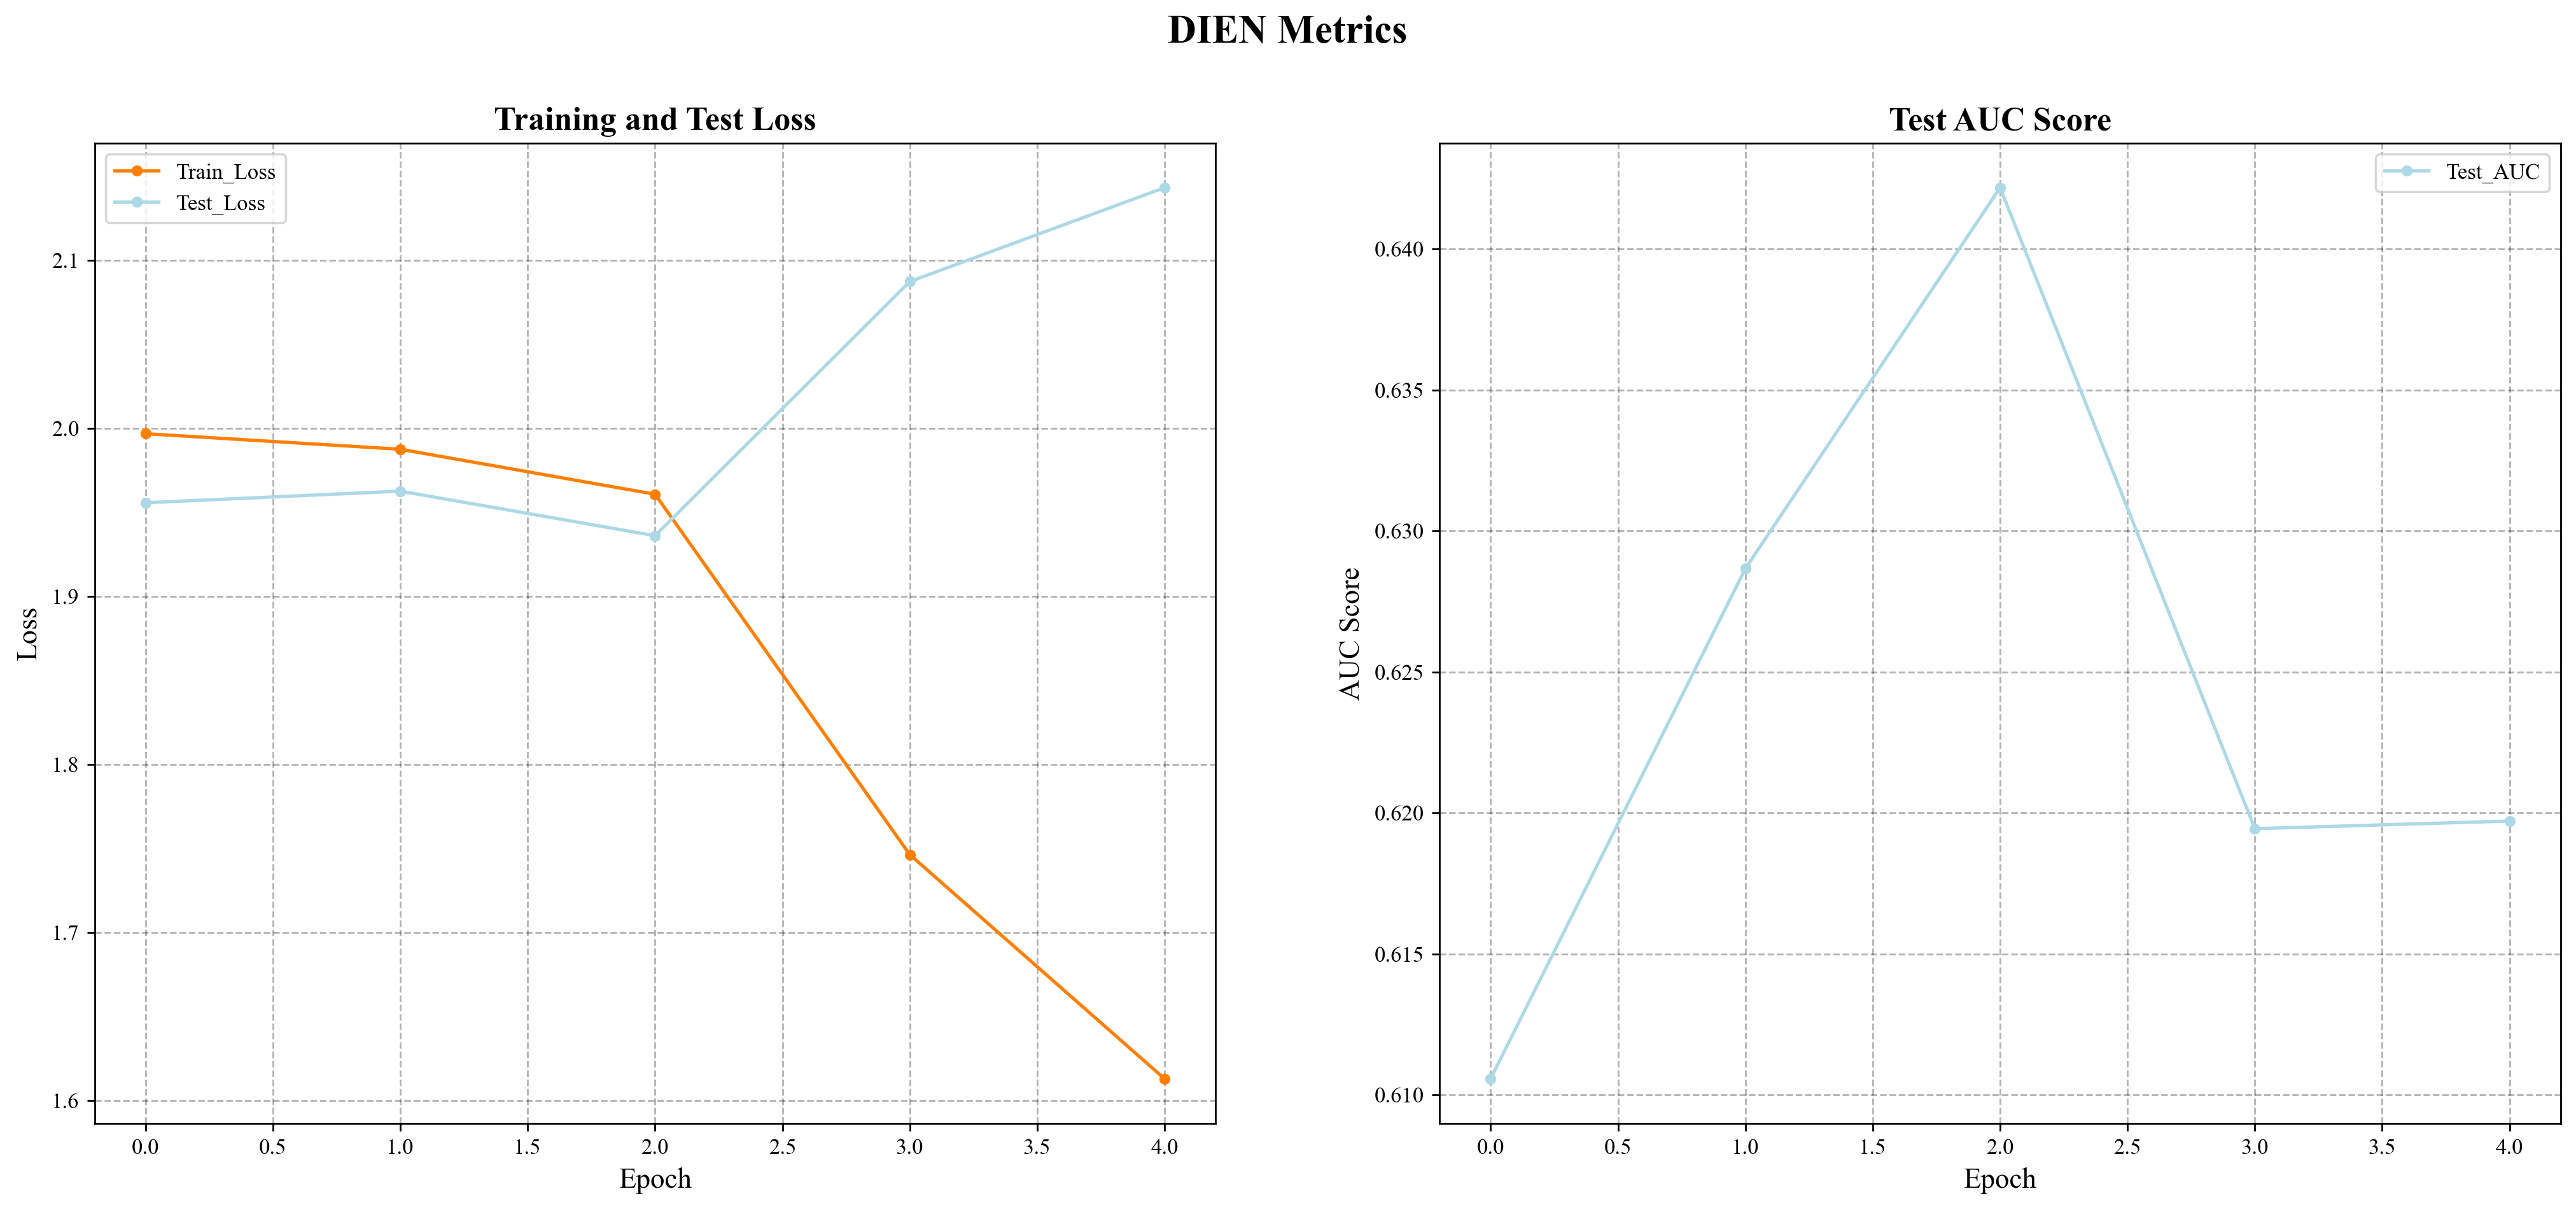

In [253]:
# 模型评估
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=250)
ax = ax.flatten()

# 绘制训练和测试损失
ax[0].set_title('Training and Test Loss', weight='bold', fontsize=15)
ax[0].set_xlabel('Epoch', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].grid(linestyle='--', alpha=0.3, color='black')
ax[0].plot(train_history , color='#FF7F00', label='Train_Loss', zorder=2, marker='o', markersize=4)
ax[0].plot(test_history, color='lightblue', label='Test_Loss', zorder=2, marker='o', markersize=4)
ax[0].legend()

# 绘制训练和测试 AUC 分数
ax[1].set_title('Test AUC Score', weight='bold', fontsize=15)
ax[1].set_xlabel('Epoch', fontsize=13)
ax[1].set_ylabel('AUC Score', fontsize=13)
ax[1].grid(linestyle='--', alpha=0.3, color='black', zorder=0)
ax[1].plot(auc_history, color='lightblue', label='Test_AUC', zorder=2, marker='o', markersize=4)
ax[1].legend()

fig.suptitle('DIEN Metrics', fontsize=18, fontweight='bold')

plt.show()